In [22]:
# Imports and configuration
%load_ext autoreload
%autoreload 2

import src.utils.file_utils as fu
import src.helpers.eda_helpers as eh
import seaborn as sns
import matplotlib.pyplot as plt

cfg_schema = fu.load_config("schema")
cfg_eda = fu.load_config("eda")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Read in raw data file
typed_hmda_data = fu.load_parquet("hmda_2024_typed")
print(typed_hmda_data.shape)

Loading dataset from /Users/c1burns/Documents/UTD/BUAN 6341/project_repo/data/interim/hmda_2024_typed.parquet
(8841112, 76)


In [3]:
# Verify target variable is binary
typed_hmda_data["denied_flag"].dtype

bool[pyarrow]

In [4]:
# Verify target variable values are all populated True/False
typed_hmda_data["denied_flag"].value_counts()

denied_flag
False    6693164
True     2147948
Name: count, dtype: int64[pyarrow]

In [5]:
# Target variable class proportions
proportions = typed_hmda_data["denied_flag"].value_counts(normalize=True)
proportions

denied_flag
False    0.75705
True     0.24295
Name: proportion, dtype: double[pyarrow]

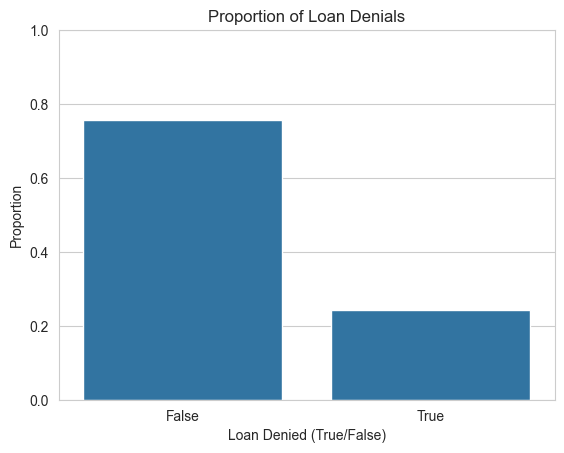

In [6]:
# Convert to DataFrame for seaborn
proportions_df = proportions.reset_index()
proportions_df.columns = ['is_denied', 'proportion']

# Get the output path
graph_output_path = fu.get_path("target_class_balance_graph")

# Create the bar plot
sns.barplot(data=proportions_df, x='is_denied', y='proportion')

plt.title('Proportion of Loan Denials')
plt.ylabel('Proportion')
plt.xlabel('Loan Denied (True/False)')
plt.ylim(0, 1)
plt.savefig(graph_output_path, dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [7]:
# Dataset is imbalanced; may require class weighting or resampling later

In [24]:
# Identify numeric columns needing review due to distributions
numeric_cols = eh.get_numeric_features(typed_hmda_data, cfg_schema)
numeric_cols_to_review = eh.get_numeric_columns_requiring_review(typed_hmda_data, numeric_cols)
numeric_cols_to_review

,skew,kurtosis,outlier_pct
income,2218.461349,5.638447e+06,0.069914
loan_amount,449.069733,4.622267e+05,NaN
property_value,279.374908,1.070047e+05,0.064134


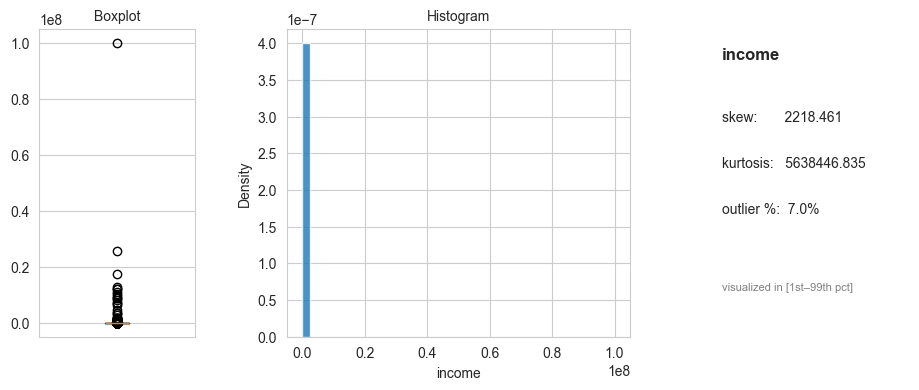

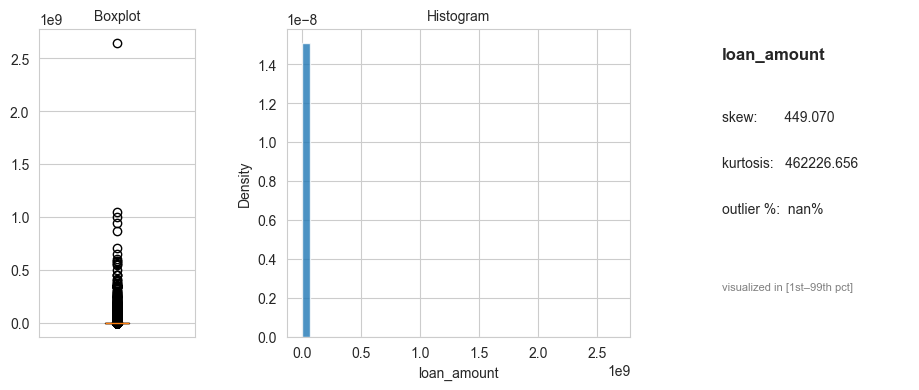

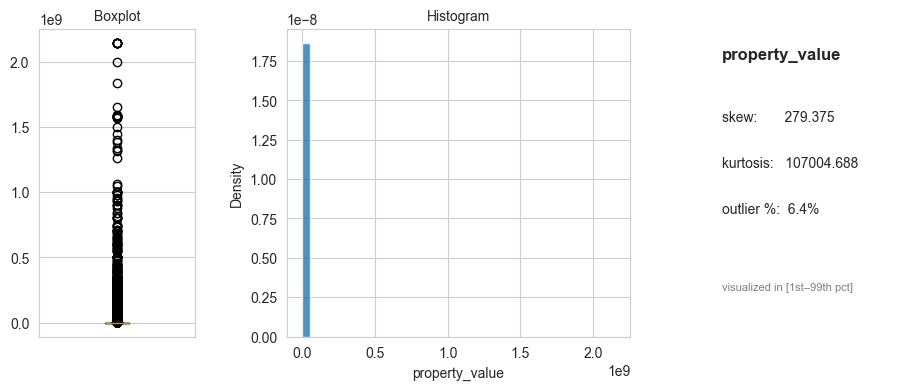

In [33]:
# Plot the numeric features that exceeded a distribution-related threshold
eh.plot_numeric_features(typed_hmda_data, numeric_cols_to_review)

Income, loan_amount, and property_value all show significant right skew with outliers as expected.  The outliers are extreme, but so is income distribution in the US so it is difficult to state that they are invalid.

Depending on the modeling method, using log transformations and perhaps capping values for these variables should be used.